In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import ADASYN
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
import shap
import plotly
import warnings
warnings.filterwarnings('ignore')
plotly.io.renderers.default = "browser"

/Users/ozerozdal/anaconda3/envs/heart-attack/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [111]:
# Importing my own functions

from decision_tree import decision_tree
from adaboost import adaboost_classifier
from knn import knn_classifier
from naive_bayes import naive_bayes
from svm import support_vector_machines
from random_forest import random_forest
from logistic_regression import logistic_regression
from xgboost_classifier import xgboost_classifier

from confusion_matrix import confusion_matrix_plot as cm_plot
from discrimination_threshold_plot import plot_discrimination_threshold as plot_threshold

In [108]:
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True) # initiate notebook for offline plot

In [3]:
# Path to data file
data = "data/echocardiogram.data"

In [4]:
# Read the .data file into a DataFrame
df = pd.read_csv(data, header=None) # Assuming there's no header in the file
df.head() # Display the first few rows of the DataFrame

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,11.0,0,71,0,0.260,9,4.600,14,1,1,name,1,0
1,19.0,0,72,0,0.380,6,4.100,14,1.700,0.588,name,1,0
2,16.0,0,55,0,0.260,4,3.420,14,1,1,name,1,0
3,57.0,0,60,0,0.253,12.062,4.603,16,1.450,0.788,name,1,0
4,19.0,1,57,0,0.160,22,5.750,18,2.250,0.571,name,1,0


In [5]:
# Define column names
column_names = ["survival", "still-alive", "age-at-heart-attack", "pericardial-effusion", "fractional-shortening",
               "epss", "lvdd", "wall-motion-score", "wall-motion-index", "mult", "name", "group", "alive-at-1"] # Add all column names here

# Assign column names to the DataFrame
df.columns = column_names

# Now you can use your DataFrame with column names assigned
df.head() # Display the first few rows of the DataFrame

,survival,still-alive,age-at-heart-attack,pericardial-effusion,fractional-shortening,epss,lvdd,wall-motion-score,wall-motion-index,mult,name,group,alive-at-1
0,11.0,0,71,0,0.260,9,4.600,14,1,1,name,1,0
1,19.0,0,72,0,0.380,6,4.100,14,1.700,0.588,name,1,0
2,16.0,0,55,0,0.260,4,3.420,14,1,1,name,1,0
3,57.0,0,60,0,0.253,12.062,4.603,16,1.450,0.788,name,1,0
4,19.0,1,57,0,0.160,22,5.750,18,2.250,0.571,name,1,0


In [6]:
# Drop irrelevant columns
df.drop(["name", "group", "mult"], axis=1, inplace=True)

In [7]:
# Check dtypes for all columns in a dataframe
df.dtypes

survival                 float64
still-alive                int64
age-at-heart-attack       object
pericardial-effusion       int64
fractional-shortening     object
epss                      object
lvdd                      object
wall-motion-score         object
wall-motion-index         object
alive-at-1                object
dtype: object

In [8]:
# Convert object columns to float
df = df.apply(pd.to_numeric, errors='coerce')

# Check the data types after conversion
print(df.dtypes)

survival                 float64
still-alive                int64
age-at-heart-attack      float64
pericardial-effusion       int64
fractional-shortening    float64
epss                     float64
lvdd                     float64
wall-motion-score        float64
wall-motion-index        float64
alive-at-1               float64
dtype: object


In [9]:
# use info() to get summary of the dataframe
summary = df.info()
print(summary)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   survival               110 non-null    float64
 1   still-alive            110 non-null    int64  
 2   age-at-heart-attack    108 non-null    float64
 3   pericardial-effusion   110 non-null    int64  
 4   fractional-shortening  103 non-null    float64
 5   epss                   96 non-null     float64
 6   lvdd                   100 non-null    float64
 7   wall-motion-score      107 non-null    float64
 8   wall-motion-index      109 non-null    float64
 9   alive-at-1             73 non-null     float64
dtypes: float64(8), int64(2)
memory usage: 8.7 KB
None


In [10]:
# Find out the percentage of missing values in each column in the given dataset
df.isnull().sum() * 100 / len(df)

survival                  0.000000
still-alive               0.000000
age-at-heart-attack       1.818182
pericardial-effusion      0.000000
fractional-shortening     6.363636
epss                     12.727273
lvdd                      9.090909
wall-motion-score         2.727273
wall-motion-index         0.909091
alive-at-1               33.636364
dtype: float64

# Feature Engineering

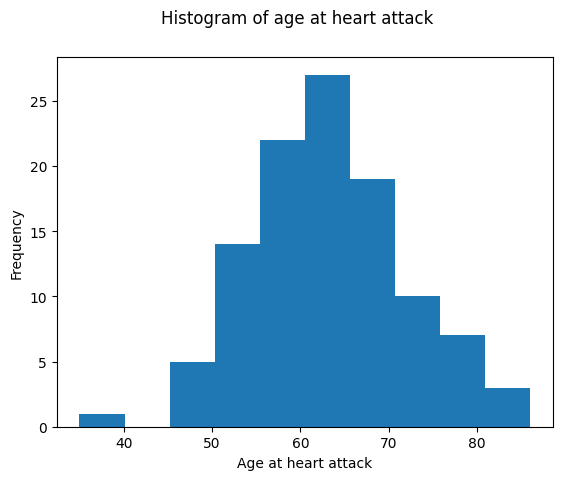

In [11]:
# Distribution of age at heart attack
ax = df['age-at-heart-attack'].plot(kind='hist',subplots=True,sharex=True,sharey=True,title='Histogram of age at heart attack', xlabel="Age at heart attack")

In [12]:
# Define age groups
bins = [0, 55, 65, 100]  # Define the age boundaries for each group
labels = ['0-55', '55-65', '65-100']  # Define labels for each group

# Create a new column for age groups
df['age_group'] = pd.cut(df['age-at-heart-attack'], bins=bins, labels=labels, right=False)

# Display the first few rows to verify
df[['age-at-heart-attack', 'age_group']].head()

,age-at-heart-attack,age_group
0,71.0,65-100
1,72.0,65-100
2,55.0,55-65
3,60.0,55-65
4,57.0,55-65


<AxesSubplot:title={'center':'Distribution of Age Groups'}, xlabel='Age Group', ylabel='# Count'>

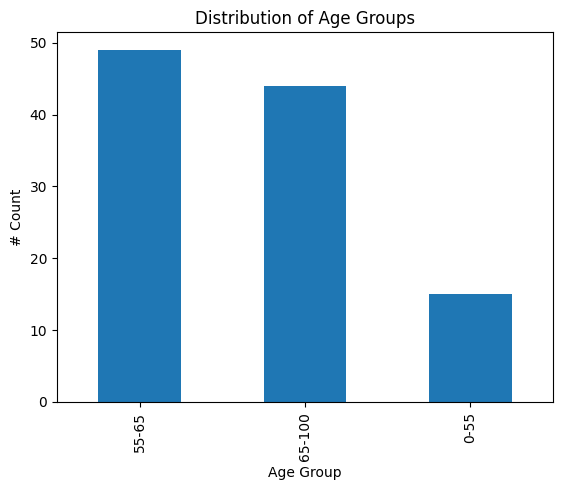

In [13]:
# Distribution of age groups
df["age_group"].value_counts().plot(kind='bar', xlabel="Age Group", ylabel="# Count", title='Distribution of Age Groups')

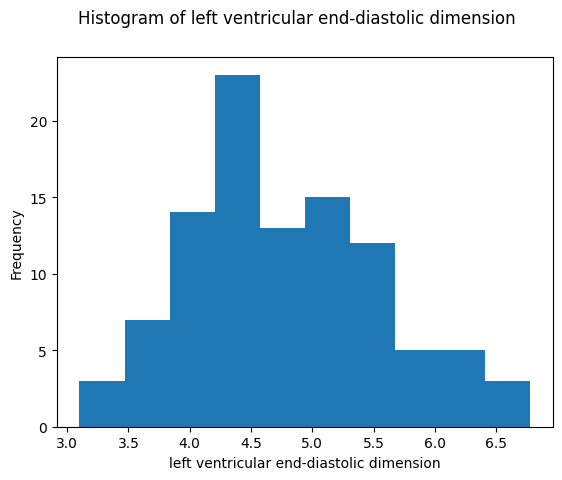

In [14]:
# Histogram of left ventricular end-diastolic dimension
ax = (df['lvdd']).plot(kind='hist',subplots=True,sharex=True,sharey=True,title='Histogram of left ventricular end-diastolic dimension', xlabel="left ventricular end-diastolic dimension")

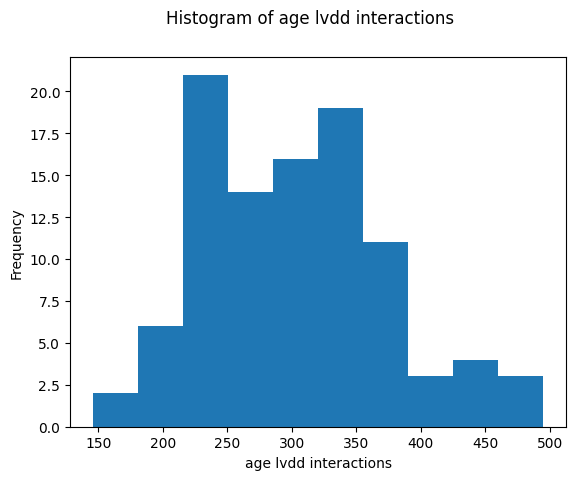

In [15]:
# Let's add age at heart attack and lvdd interaction term
df['age_lvdd_interaction'] = df['age-at-heart-attack'] * df['lvdd']
ax = (df['age_lvdd_interaction']).plot(kind='hist',subplots=True,sharex=True,sharey=True,title='Histogram of age lvdd interactions', xlabel="age lvdd interactions")

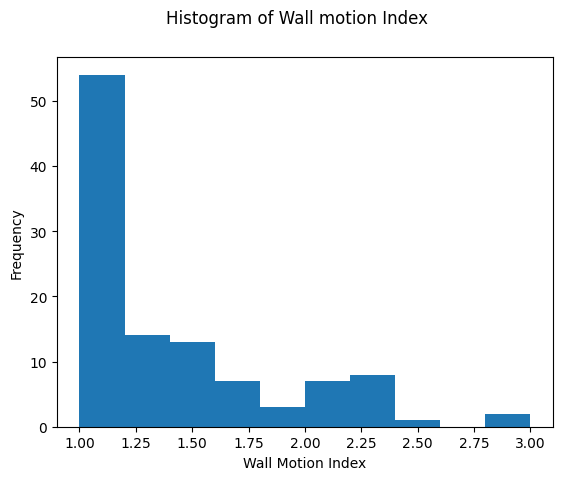

In [16]:
# Histogram of wall-motion-index
ax = (df['wall-motion-index']).plot(kind='hist',subplots=True,sharex=True,sharey=True,title='Histogram of Wall motion Index', xlabel="Wall Motion Index")

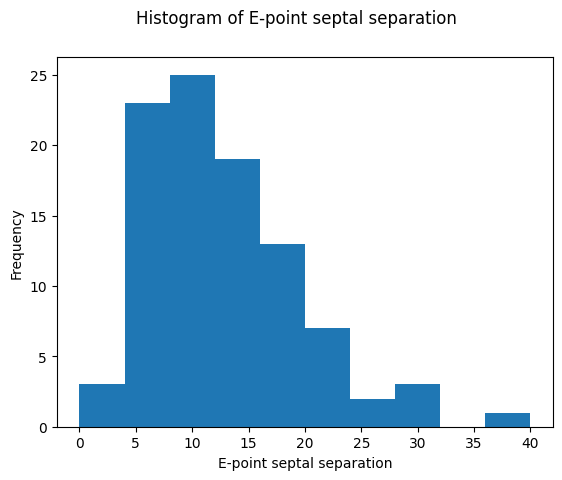

In [17]:
# Histogram of E-point septal separation
ax = (df['epss']).plot(kind='hist',subplots=True,sharex=True,sharey=True,title='Histogram of E-point septal separation', xlabel="E-point septal separation")

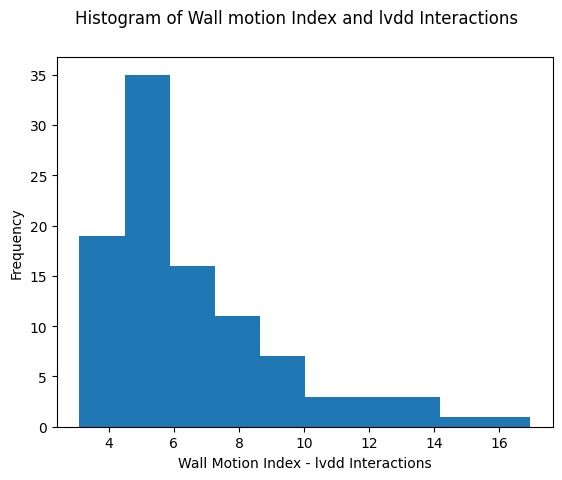

In [18]:
# Let's add wall-motion-index and lvdd interaction term
df['wall-motion-index_lvdd_interaction'] = df['wall-motion-index'] * df['lvdd']
ax = (df['wall-motion-index_lvdd_interaction']).plot(kind='hist',subplots=True,sharex=True,sharey=True,title='Histogram of Wall motion Index and lvdd Interactions', xlabel="Wall Motion Index - lvdd Interactions")

<AxesSubplot:title={'center':'Distribution of Pericardial effusion'}, xlabel='Pericardial effusion', ylabel='# Count'>

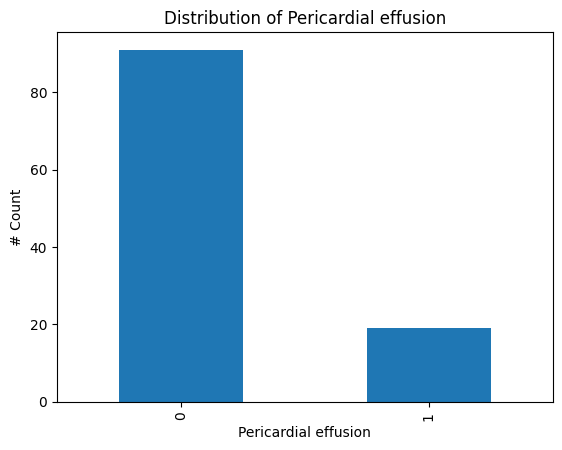

In [19]:
# Distribution of Pericardial effusion
df["pericardial-effusion"].value_counts().plot(kind='bar', xlabel="Pericardial effusion", ylabel="# Count", title='Distribution of Pericardial effusion')

array([<AxesSubplot:xlabel='fractional-shortening', ylabel='Frequency'>],
      dtype=object)

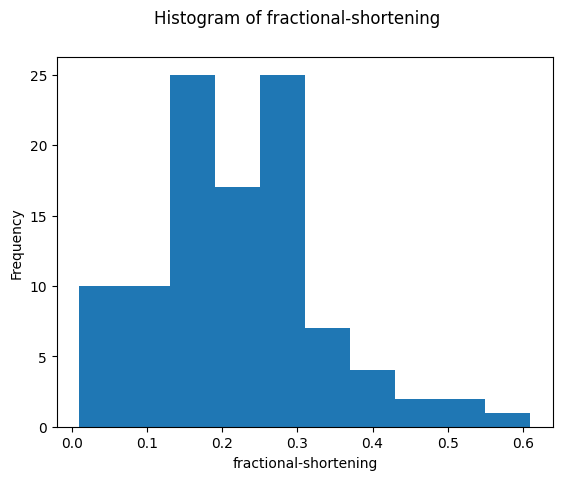

In [20]:
# Distribution of fractional-shortening
df["fractional-shortening"].plot(kind='hist',subplots=True,sharex=True,sharey=True,title='Histogram of fractional-shortening', xlabel="fractional-shortening")

# Preparation of Labelled Data

In [21]:
# Select all patients who either survived beyond a two-year period or who passed away within two years of diagnosis.
df_labelled = df[ (df["survival"] >= 24) | (df["survival"] < 24) & (df["still-alive"] == 0) ].copy()
df_labelled['target'] = df_labelled["still-alive"].astype(int) # 1 if survived at least 2 years, else 0
df_labelled.head()

,survival,still-alive,age-at-heart-attack,pericardial-effusion,fractional-shortening,epss,lvdd,wall-motion-score,wall-motion-index,alive-at-1,age_group,age_lvdd_interaction,wall-motion-index_lvdd_interaction,target
0,11.0,0,71.0,0,0.260,9.000,4.600,14.0,1.00,0.0,65-100,326.60,4.60000,0
1,19.0,0,72.0,0,0.380,6.000,4.100,14.0,1.70,0.0,65-100,295.20,6.97000,0
2,16.0,0,55.0,0,0.260,4.000,3.420,14.0,1.00,0.0,55-65,188.10,3.42000,0
3,57.0,0,60.0,0,0.253,12.062,4.603,16.0,1.45,0.0,55-65,276.18,6.67435,0
5,26.0,0,68.0,0,0.260,5.000,4.310,12.0,1.00,0.0,65-100,293.08,4.31000,0


In [22]:
# Find out the percentage of missing values in each column in the given dataset
df_labelled.isnull().sum() * 100 / len(df_labelled)

survival                               0.000000
still-alive                            0.000000
age-at-heart-attack                    0.000000
pericardial-effusion                   0.000000
fractional-shortening                  4.225352
epss                                  11.267606
lvdd                                   4.225352
wall-motion-score                      1.408451
wall-motion-index                      0.000000
alive-at-1                            35.211268
age_group                              0.000000
age_lvdd_interaction                   4.225352
wall-motion-index_lvdd_interaction     4.225352
target                                 0.000000
dtype: float64

In [23]:
# Drop unnecessary columns
df_labelled.drop(["survival", "still-alive", "alive-at-1", "wall-motion-score"], axis=1, inplace=True)
df_labelled.dropna(inplace=True) # Handle missing values
df_labelled.head()

,age-at-heart-attack,pericardial-effusion,fractional-shortening,epss,lvdd,wall-motion-index,age_group,age_lvdd_interaction,wall-motion-index_lvdd_interaction,target
0,71.0,0,0.260,9.000,4.600,1.00,65-100,326.60,4.60000,0
1,72.0,0,0.380,6.000,4.100,1.70,65-100,295.20,6.97000,0
2,55.0,0,0.260,4.000,3.420,1.00,55-65,188.10,3.42000,0
3,60.0,0,0.253,12.062,4.603,1.45,55-65,276.18,6.67435,0
5,68.0,0,0.260,5.000,4.310,1.00,65-100,293.08,4.31000,0


In [24]:
# Dimensions of the df_labelled dataframe
df_labelled.shape

(61, 10)

In [25]:
# Imbalanced target distribution
df_labelled["target"].value_counts()

target
0    60
1     1
Name: count, dtype: int64

In [26]:
# Let's find that one patient!
# Select all patients who either survived beyond a two-year period
df_labelled[df_labelled["target"] == 1]

,age-at-heart-attack,pericardial-effusion,fractional-shortening,epss,lvdd,wall-motion-index,age_group,age_lvdd_interaction,wall-motion-index_lvdd_interaction,target
94,74.0,0,0.2,4.8,4.56,1.04,65-100,337.44,4.7424,1


In [27]:
# use info() to get summary of the dataframe
df_labelled.info()

<class 'pandas.core.frame.DataFrame'>
Index: 61 entries, 0 to 109
Data columns (total 10 columns):
 #   Column                              Non-Null Count  Dtype   
---  ------                              --------------  -----   
 0   age-at-heart-attack                 61 non-null     float64 
 1   pericardial-effusion                61 non-null     int64   
 2   fractional-shortening               61 non-null     float64 
 3   epss                                61 non-null     float64 
 4   lvdd                                61 non-null     float64 
 5   wall-motion-index                   61 non-null     float64 
 6   age_group                           61 non-null     category
 7   age_lvdd_interaction                61 non-null     float64 
 8   wall-motion-index_lvdd_interaction  61 non-null     float64 
 9   target                              61 non-null     int64   
dtypes: category(1), float64(7), int64(2)
memory usage: 5.0 KB


In [28]:
# Columns of the dataframe
df_labelled.columns.tolist()

['age-at-heart-attack',
 'pericardial-effusion',
 'fractional-shortening',
 'epss',
 'lvdd',
 'wall-motion-index',
 'age_group',
 'age_lvdd_interaction',
 'wall-motion-index_lvdd_interaction',
 'target']

In [29]:
# Change the order of DataFrame columns to prepare it for Label Encoding for the 'age_group' and 'pericardial-effusion' column

df_labelled = df_labelled[[
    'age_group',
    'pericardial-effusion',
    'age-at-heart-attack',
    'fractional-shortening',
    'epss',
    'lvdd',
    'wall-motion-index',
    'age_lvdd_interaction',
    'wall-motion-index_lvdd_interaction',
    'target']]

df_labelled.head()

,age_group,pericardial-effusion,age-at-heart-attack,fractional-shortening,epss,lvdd,wall-motion-index,age_lvdd_interaction,wall-motion-index_lvdd_interaction,target
0,65-100,0,71.0,0.260,9.000,4.600,1.00,326.60,4.60000,0
1,65-100,0,72.0,0.380,6.000,4.100,1.70,295.20,6.97000,0
2,55-65,0,55.0,0.260,4.000,3.420,1.00,188.10,3.42000,0
3,55-65,0,60.0,0.253,12.062,4.603,1.45,276.18,6.67435,0
5,65-100,0,68.0,0.260,5.000,4.310,1.00,293.08,4.31000,0


In [30]:
# df_labelled dataframe statistics
df_labelled.describe()

,pericardial-effusion,age-at-heart-attack,fractional-shortening,epss,lvdd,wall-motion-index,age_lvdd_interaction,wall-motion-index_lvdd_interaction,target
count,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000
mean,0.114754,61.344262,0.243689,10.679426,4.591197,1.262230,282.419180,5.817130,0.016393
std,0.321370,8.767146,0.110567,6.187680,0.756471,0.353716,64.709125,2.042434,0.128037
min,0.000000,35.000000,0.036000,0.000000,3.100000,1.000000,145.700000,3.100000,0.000000
25%,0.000000,55.000000,0.170000,6.000000,4.120000,1.000000,238.360000,4.480000,0.000000
50%,0.000000,61.000000,0.250000,9.700000,4.490000,1.100000,279.040000,5.343100,0.000000
75%,0.000000,66.000000,0.300000,13.100000,5.150000,1.450000,322.920000,6.489600,0.000000
max,1.000000,80.000000,0.610000,31.000000,6.740000,2.390000,438.360000,14.220500,1.000000


In [31]:
# At present, executing an ML model is not feasible due to the significant imbalance in the target distribution. 
# To address this issue, I will initiate an unsupervised clustering process on the unlabeled data. 
# Subsequently, I will assign labels to the clustered data and integrate them into the 'df_labelled' dataframe.
# This approach aims to augment the number of positive samples and improve the balance within the dataset.

df_labelled["target"].value_counts()

target
0    60
1     1
Name: count, dtype: int64

# Preparation of Unlabelled Data

In [32]:
# Unlabelled data
df_unlabelled = df[ (df["survival"] < 24) & (df["still-alive"] == 1) ]

# Drop unnecessary columns
df_unlabelled.drop(["survival", "still-alive", "alive-at-1", "wall-motion-score"], axis=1, inplace=True)
df_unlabelled.dropna(inplace=True) # Handle missing values

# Change the order of DataFrame columns to prepare it for Label Encoding for the 'age_group' and 'pericardial-effusion' column
df_unlabelled = df_unlabelled[[
    'age_group',
    'pericardial-effusion',
    'age-at-heart-attack',
    'fractional-shortening',
    'epss',
    'lvdd',
    'wall-motion-index',
    'age_lvdd_interaction',
    'wall-motion-index_lvdd_interaction']]

df_unlabelled.head()


,age_group,pericardial-effusion,age-at-heart-attack,fractional-shortening,epss,lvdd,wall-motion-index,age_lvdd_interaction,wall-motion-index_lvdd_interaction
4,55-65,0,57.000,0.16,22.0,5.75,2.25,327.7500,12.9375
10,65-100,0,77.000,0.13,16.0,4.23,1.80,325.7100,7.6140
14,55-65,0,62.000,0.12,23.0,5.80,2.33,359.6000,13.5140
16,65-100,1,69.000,0.26,11.0,4.65,1.64,320.8500,7.6260
17,55-65,1,62.529,0.07,20.0,5.20,2.00,325.1508,10.4000


In [33]:
# Dimensions of the df_unlabelled dataframe
df_unlabelled.shape

(29, 9)

# Data Labelling Using Unsupervised Machine Learning

In [34]:
# k-Means Clustering on Unlabelled Data
# In other words, patients who had an heart attack within the past two years and are currently alive.
X_unlabelled = df_unlabelled.values
X_unlabelled_columns = df_unlabelled.columns.tolist()

# Feature Scaling
sc = StandardScaler()
X_unlabelled[:, 2:] = sc.fit_transform(X_unlabelled[:, 2:])
X_unlabelled = pd.DataFrame(X_unlabelled, columns=X_unlabelled_columns)

# Encoding categorical data -> age_group and pericardial-effusion
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [0, 1])], remainder='passthrough')
X_unlabelled = np.array(ct.fit_transform(X_unlabelled))
X_unlabelled = pd.DataFrame(X_unlabelled, columns=ct.get_feature_names_out())
X_unlabelled.head()


,encoder__age_group_0-55,encoder__age_group_55-65,encoder__age_group_65-100,encoder__pericardial-effusion_0,encoder__pericardial-effusion_1,remainder__age-at-heart-attack,remainder__fractional-shortening,remainder__epss,remainder__lvdd,remainder__wall-motion-index,remainder__age_lvdd_interaction,remainder__wall-motion-index_lvdd_interaction
0,0.0,1.0,0.0,1.0,0.0,-1.121494,-0.087261,0.809901,0.816239,1.281284,-0.233672,1.44108
1,0.0,0.0,1.0,1.0,0.0,1.205515,-0.432341,0.029455,-1.246706,0.393393,-0.266161,-0.225763
2,0.0,1.0,0.0,1.0,0.0,-0.539742,-0.547367,0.939975,0.884099,1.439131,0.273564,1.621588
3,0.0,0.0,1.0,0.0,1.0,0.274711,1.063003,-0.620916,-0.676682,0.077699,-0.34356,-0.222006
4,0.0,1.0,0.0,0.0,1.0,-0.478192,-1.122499,0.549752,0.069779,0.788012,-0.275067,0.646562


In [35]:
# Hierarchical Clustering
hc = AgglomerativeClustering(n_clusters = 2, linkage = 'ward')
y_cluster = hc.fit_predict(X_unlabelled)
y_cluster

array([1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0])

In [36]:
# Distribution of two clusters
pd.Series(y_cluster).value_counts()

0    22
1     7
Name: count, dtype: int64

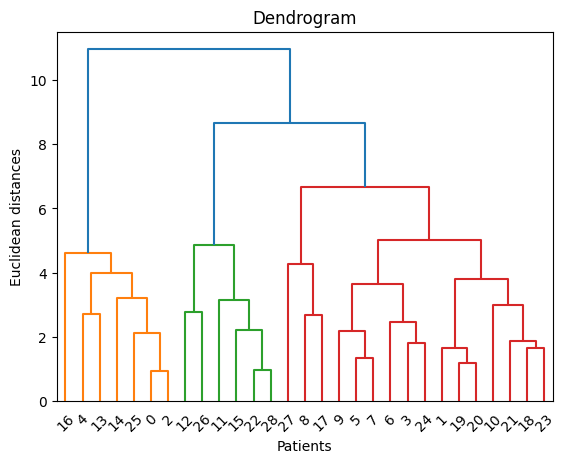

In [37]:
#Using the dendrogram to find the optimal number of clusters
dendrogram = sch.dendrogram(sch.linkage(X_unlabelled, method = 'ward'))
plt.title('Dendrogram')
plt.xlabel('Patients')
plt.ylabel('Euclidean distances')
plt.show()

In [38]:
# Let's find out X_unlabelled column names
X_unlabelled.columns

Index(['encoder__age_group_0-55', 'encoder__age_group_55-65',
       'encoder__age_group_65-100', 'encoder__pericardial-effusion_0',
       'encoder__pericardial-effusion_1', 'remainder__age-at-heart-attack',
       'remainder__fractional-shortening', 'remainder__epss',
       'remainder__lvdd', 'remainder__wall-motion-index',
       'remainder__age_lvdd_interaction',
       'remainder__wall-motion-index_lvdd_interaction'],
      dtype='object')

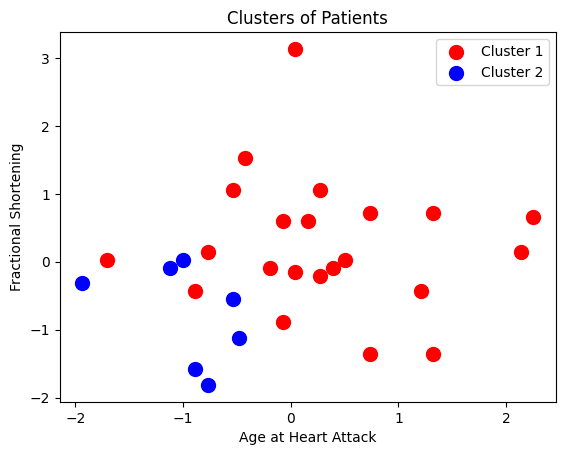

In [39]:
# Clustering Results
plt.scatter(X_unlabelled[y_cluster == 0]["remainder__age-at-heart-attack"], X_unlabelled[y_cluster == 0]["remainder__fractional-shortening"], s = 100, c = 'red', label = 'Cluster 1')
plt.scatter(X_unlabelled[y_cluster == 1]["remainder__age-at-heart-attack"], X_unlabelled[y_cluster == 1]["remainder__fractional-shortening"], s = 100, c = 'blue', label = 'Cluster 2')
plt.title('Clusters of Patients')
plt.xlabel('Age at Heart Attack')
plt.ylabel('Fractional Shortening')
plt.legend()
plt.show()

In [40]:
# DATA LABELLING

# I assume that the patients of Cluster 1 (red points) will unfortunately pass away within 2 years 
# while the patients of Cluster 2 will survive at least 2 years

# Cluster 1 means y_cluster == 0
# Cluster 2 means y_cluster == 1

# Creating a new column 'target'. If y_cluster equals to 0, target value will be 0, as well.
# Otherwise, target value will be assigned as 1.
df_unlabelled["target"] = np.where(y_cluster == 0, 0, 1)
df_unlabelled.head()

,age_group,pericardial-effusion,age-at-heart-attack,fractional-shortening,epss,lvdd,wall-motion-index,age_lvdd_interaction,wall-motion-index_lvdd_interaction,target
4,55-65,0,57.000,0.16,22.0,5.75,2.25,327.7500,12.9375,1
10,65-100,0,77.000,0.13,16.0,4.23,1.80,325.7100,7.6140,0
14,55-65,0,62.000,0.12,23.0,5.80,2.33,359.6000,13.5140,1
16,65-100,1,69.000,0.26,11.0,4.65,1.64,320.8500,7.6260,0
17,55-65,1,62.529,0.07,20.0,5.20,2.00,325.1508,10.4000,1


In [41]:
# concatenating df_labelled and df_unlabelled along rows
X_labelled = pd.concat([df_labelled, df_unlabelled], axis=0)
X_labelled.head()

,age_group,pericardial-effusion,age-at-heart-attack,fractional-shortening,epss,lvdd,wall-motion-index,age_lvdd_interaction,wall-motion-index_lvdd_interaction,target
0,65-100,0,71.0,0.260,9.000,4.600,1.00,326.60,4.60000,0
1,65-100,0,72.0,0.380,6.000,4.100,1.70,295.20,6.97000,0
2,55-65,0,55.0,0.260,4.000,3.420,1.00,188.10,3.42000,0
3,55-65,0,60.0,0.253,12.062,4.603,1.45,276.18,6.67435,0
5,65-100,0,68.0,0.260,5.000,4.310,1.00,293.08,4.31000,0


In [42]:
print("Original Labelled Data", df_labelled.shape)
print("Original Unlabelled Data", df_unlabelled.shape)
print("Updated Labelled Data Using Clustering", X_labelled.shape)

Original Labelled Data (61, 10)
Original Unlabelled Data (29, 10)
Updated Labelled Data Using Clustering (90, 10)


In [43]:
X_labelled["target"].value_counts() # Still imbalanced dataset

target
0    82
1     8
Name: count, dtype: int64

In [44]:
X_labelled.head()

,age_group,pericardial-effusion,age-at-heart-attack,fractional-shortening,epss,lvdd,wall-motion-index,age_lvdd_interaction,wall-motion-index_lvdd_interaction,target
0,65-100,0,71.0,0.260,9.000,4.600,1.00,326.60,4.60000,0
1,65-100,0,72.0,0.380,6.000,4.100,1.70,295.20,6.97000,0
2,55-65,0,55.0,0.260,4.000,3.420,1.00,188.10,3.42000,0
3,55-65,0,60.0,0.253,12.062,4.603,1.45,276.18,6.67435,0
5,65-100,0,68.0,0.260,5.000,4.310,1.00,293.08,4.31000,0


# Preparation for Classification 

In [45]:
# Encoding categorical data -> age_group and pericardial-effusion
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [0, 1])], remainder='passthrough') # [0, 1] refers to age_group and pericardial-effusion columns
X_encoded = np.array(ct.fit_transform(X_labelled.iloc[:, :-1]))
X_encoded = pd.DataFrame(X_encoded, columns=ct.get_feature_names_out())
X_encoded.head()

,encoder__age_group_0-55,encoder__age_group_55-65,encoder__age_group_65-100,encoder__pericardial-effusion_0,encoder__pericardial-effusion_1,remainder__age-at-heart-attack,remainder__fractional-shortening,remainder__epss,remainder__lvdd,remainder__wall-motion-index,remainder__age_lvdd_interaction,remainder__wall-motion-index_lvdd_interaction
0,0.0,0.0,1.0,1.0,0.0,71.0,0.260,9.000,4.600,1.00,326.60,4.60000
1,0.0,0.0,1.0,1.0,0.0,72.0,0.380,6.000,4.100,1.70,295.20,6.97000
2,0.0,1.0,0.0,1.0,0.0,55.0,0.260,4.000,3.420,1.00,188.10,3.42000
3,0.0,1.0,0.0,1.0,0.0,60.0,0.253,12.062,4.603,1.45,276.18,6.67435
4,0.0,0.0,1.0,1.0,0.0,68.0,0.260,5.000,4.310,1.00,293.08,4.31000


In [46]:
# X_encoded column names
X_encoded.columns

Index(['encoder__age_group_0-55', 'encoder__age_group_55-65',
       'encoder__age_group_65-100', 'encoder__pericardial-effusion_0',
       'encoder__pericardial-effusion_1', 'remainder__age-at-heart-attack',
       'remainder__fractional-shortening', 'remainder__epss',
       'remainder__lvdd', 'remainder__wall-motion-index',
       'remainder__age_lvdd_interaction',
       'remainder__wall-motion-index_lvdd_interaction'],
      dtype='object')

In [47]:
# Encoding the Dependent Variable (Target)
le = LabelEncoder()
y = X_labelled['target']
y_encoded = le.fit_transform(y)
y_encoded

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0])

In [48]:
# Oversampling using ADASYN

# set up ADASYN
sampler = ADASYN(
    sampling_strategy = 'auto', # samples only the minority class
    random_state = 42, # for reproducibility
    n_neighbors = 5,
    n_jobs = 4
)

X_res, y_res = sampler.fit_resample(X_encoded, y_encoded)

In [49]:
pd.Series(y_res).value_counts() # Balanced target distribution thanks to oversampling (ADASYN) 

0    82
1    82
Name: count, dtype: int64

In [50]:
# Features dataframe after oversampling
X_res.head()

,encoder__age_group_0-55,encoder__age_group_55-65,encoder__age_group_65-100,encoder__pericardial-effusion_0,encoder__pericardial-effusion_1,remainder__age-at-heart-attack,remainder__fractional-shortening,remainder__epss,remainder__lvdd,remainder__wall-motion-index,remainder__age_lvdd_interaction,remainder__wall-motion-index_lvdd_interaction
0,0.0,0.0,1.0,1.0,0.0,71.0,0.260,9.000,4.600,1.00,326.60,4.60000
1,0.0,0.0,1.0,1.0,0.0,72.0,0.380,6.000,4.100,1.70,295.20,6.97000
2,0.0,1.0,0.0,1.0,0.0,55.0,0.260,4.000,3.420,1.00,188.10,3.42000
3,0.0,1.0,0.0,1.0,0.0,60.0,0.253,12.062,4.603,1.45,276.18,6.67435
4,0.0,0.0,1.0,1.0,0.0,68.0,0.260,5.000,4.310,1.00,293.08,4.31000


In [51]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.35, random_state=42)

# Feature Scaling
sc = StandardScaler()
X_train.iloc[:, 5:] = sc.fit_transform(X_train.iloc[:, 5:].values) # Excluding the first 5 OneHot Encoded columns (categorical variables) 
X_test.iloc[:, 5:] = sc.transform(X_test.iloc[:, 5:].values) # Excluding the first 5 OneHot Encoded columns (categorical variables) 

In [52]:
# Convert the scaled numpy array back into a DataFrame
X_train_df = pd.DataFrame(X_train, columns=ct.get_feature_names_out())
X_train_df.shape

(106, 12)

In [53]:
# Convert the scaled numpy array back into a DataFrame
X_test_df = pd.DataFrame(X_test, columns=ct.get_feature_names_out())
X_test_df.shape

(58, 12)

# Running Classifiers

In [54]:
# Check out *.py files (attached) to see the content of these functions

knn_best_params, knn_best_estimator = knn_classifier(X_train, y_train, X_test, y_test)
nb_best_params, nb_best_estimator = naive_bayes(X_train, y_train, X_test, y_test)
dt_best_params, dt_best_estimator = decision_tree(X_train, y_train, X_test, y_test)
lr_best_params, lr_best_estimator = logistic_regression(X_train, y_train, X_test, y_test)
rf_best_params, rf_best_estimator = random_forest(X_train, y_train, X_test, y_test)
svm_best_params, svm_best_estimator = support_vector_machines(X_train, y_train, X_test, y_test)
xgboost_best_params, xgboost_best_estimator = xgboost_classifier(X_train, y_train, X_test, y_test)
adaboost_best_params, adaboost_best_estimator = adaboost_classifier(X_train, y_train, X_test, y_test)



============================= KNN Classifier ==================================


Best Parameters: {'algorithm': 'auto', 'leaf_size': 10, 'metric': 'manhattan', 'n_neighbors': 19, 'p': 1, 'weights': 'distance'}
F1 Macro Score: 96.85 %
Accuracy: 86.21 %
Standard Deviation of Cross Validation Scores: 1.60 %
Confusion Matrix:
 [[23  8]
 [ 0 27]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.74      0.85        31
           1       0.77      1.00      0.87        27

    accuracy                           0.86        58
   macro avg       0.89      0.87      0.86        58
weighted avg       0.89      0.86      0.86        58



============================= Naive Bayes Classifier ==================================
Best Parameters: {'priors': None}
F1 Macro Score: 92.48 %
Accuracy: 87.93 %
Standard Deviation of Cross Validation Scores: 0.00 %
Confusion Matrix:
 [[29  2]
 [ 5 22]]
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.94      0.89      

# Predictions on New Data Set (Test)

In [55]:
def prep_test_data():

    test_data = "data/echocardiogram.test"

    # Read the .data file into a DataFrame
    df = pd.read_csv(test_data, header=None) # Assuming there's no header in the file

    # Define column names
    column_names = ["survival", "still-alive", "age-at-heart-attack", "pericardial-effusion", "fractional-shortening",
                "epss", "lvdd", "wall-motion-score", "wall-motion-index", "mult", "name", "group", "alive-at-1"] # Add all column names here

    # Assign column names to the DataFrame
    df.columns = column_names

    # Drop irrelevant columns
    df.drop(["survival", "still-alive", "name", "group", "mult", "wall-motion-score", "alive-at-1"], axis=1, inplace=True)

    # Convert object columns to float
    df = df.apply(pd.to_numeric, errors='coerce').copy()
    #df.apply(pd.to_numeric, errors='coerce')

    # Handling missing values
    df.dropna(inplace=True)

    # Define age groups
    bins = [0, 55, 65, 100]  # Define the age boundaries for each group
    labels = ['0-55', '55-65', '65-100']  # Define labels for each group

    # Create a new column for age groups
    df['age_group'] = pd.cut(df['age-at-heart-attack'], bins=bins, labels=labels, right=False)

    # Let's add wall-motion-index and lvdd interaction term
    df['wall-motion-index_lvdd_interaction'] = df['wall-motion-index'] * df['lvdd']

    # Let's add age at heart attack and lvdd interaction term
    df['age_lvdd_interaction'] = df['age-at-heart-attack'] * df['lvdd']

    # Change the order of DataFrame columns to prepare it for Label Encoding for the 'age_group' and 'pericardial-effusion' column
    df = df[[
        'age_group',
        'pericardial-effusion',
        'age-at-heart-attack',
        'fractional-shortening',
        'epss',
        'lvdd',
        'wall-motion-index',
        'age_lvdd_interaction',
        'wall-motion-index_lvdd_interaction']].copy()

    # Encoding categorical data -> age_group and pericardial-effusion
    ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [0, 1])], remainder='passthrough') # [0, 1] refers to age_group and pericardial-effusion columns
    df_array = np.array(ct.fit_transform(df))
    dff = pd.DataFrame(df_array, columns=ct.get_feature_names_out(), index=df.index)

    # Feature Scaling
    dff.iloc[:, 5:] = sc.transform(dff.iloc[:, 5:].values) # Excluding the first two columns (categorical variables) and the last target column

    return dff


In [56]:
test_data_df = prep_test_data()

# Now you can use your DataFrame with column names assigned
test_data_df.head() # Display the first few rows of the DataFrame


,encoder__age_group_0-55,encoder__age_group_55-65,encoder__age_group_65-100,encoder__pericardial-effusion_0,encoder__pericardial-effusion_1,remainder__age-at-heart-attack,remainder__fractional-shortening,remainder__epss,remainder__lvdd,remainder__wall-motion-index,remainder__age_lvdd_interaction,remainder__wall-motion-index_lvdd_interaction
0,0.0,1.0,0.0,1.0,0.0,-0.116303,0.980550,-0.821905,-1.339684,-1.244533,-1.195332,-1.357084
1,0.0,1.0,0.0,0.0,1.0,-0.393886,2.306776,-0.796000,0.259605,-1.244533,-0.021385,-0.975000
2,0.0,1.0,0.0,1.0,0.0,-0.671469,1.184584,-0.770095,-0.466226,-1.244533,-0.780565,-1.148407
3,0.0,1.0,0.0,0.0,1.0,0.022489,0.164410,1.755607,1.821988,0.571824,1.601737,1.249466
5,1.0,0.0,0.0,1.0,0.0,-1.087844,2.612828,-0.783048,-0.441622,-1.244533,-1.007035,-1.142529


In [57]:
# Predictions by Random Forest 
y_pred_rf = rf_best_estimator.predict(test_data_df)
y_pred_prob_rf = np.max(rf_best_estimator.predict_proba(test_data_df), axis=1)

# Predictions by XGBoost Classifier
y_pred_xg = xgboost_best_estimator.predict(test_data_df)
y_pred_prob_xg = np.max(xgboost_best_estimator.predict_proba(test_data_df), axis=1)


In [58]:
# Adding predictions and prediction probabilities as new columns in the data frame

test_data_df["Prediction RF"] = y_pred_rf.astype(int)
test_data_df["Prediction Probability RF"] = y_pred_prob_rf

test_data_df["Prediction XGBoost"] = y_pred_xg.astype(int)
test_data_df["Prediction Probability XGBoost"] = y_pred_prob_xg

In [59]:
# Let's take a look at the last 4 columns
test_data_df

,encoder__age_group_0-55,encoder__age_group_55-65,encoder__age_group_65-100,encoder__pericardial-effusion_0,encoder__pericardial-effusion_1,remainder__age-at-heart-attack,remainder__fractional-shortening,remainder__epss,remainder__lvdd,remainder__wall-motion-index,remainder__age_lvdd_interaction,remainder__wall-motion-index_lvdd_interaction,Prediction RF,Prediction Probability RF,Prediction XGBoost,Prediction Probability XGBoost
0,0.0,1.0,0.0,1.0,0.0,-0.116303,0.980550,-0.821905,-1.339684,-1.244533,-1.195332,-1.357084,0,1.00,0,0.907499
1,0.0,1.0,0.0,0.0,1.0,-0.393886,2.306776,-0.796000,0.259605,-1.244533,-0.021385,-0.975000,0,0.91,0,0.907499
2,0.0,1.0,0.0,1.0,0.0,-0.671469,1.184584,-0.770095,-0.466226,-1.244533,-0.780565,-1.148407,0,0.97,0,0.907499
3,0.0,1.0,0.0,0.0,1.0,0.022489,0.164410,1.755607,1.821988,0.571824,1.601737,1.249466,1,0.91,1,0.865458
5,1.0,0.0,0.0,1.0,0.0,-1.087844,2.612828,-0.783048,-0.441622,-1.244533,-1.007035,-1.142529,0,0.97,0,0.907499
6,0.0,1.0,0.0,0.0,1.0,0.022489,0.674497,1.716750,0.874717,0.571824,0.784527,0.808158,1,0.57,0,0.758967
8,0.0,1.0,0.0,1.0,0.0,0.300072,-0.243659,-1.132760,-1.204360,-0.728305,-0.866326,-0.993840,0,0.89,0,0.851955
9,0.0,1.0,0.0,0.0,1.0,-0.671469,-0.549711,-1.987613,-3.480272,-0.527550,-3.171083,-1.612787,0,0.92,0,0.851955
10,0.0,1.0,0.0,1.0,0.0,-0.116303,0.062393,-1.987613,-0.822991,-0.527550,-0.756771,-0.739871,0,0.89,0,0.849042
11,0.0,1.0,0.0,0.0,1.0,-0.116303,0.164410,-0.277907,-0.134066,0.151194,-0.172023,0.012306,1,0.59,0,0.657621


In [60]:
def prep_test_data(prediction_df):

    # path to test file
    test_data = "data/echocardiogram.test"

    # Read the .data file into a DataFrame
    df_test_data = pd.read_csv(test_data, header=None) # Assuming there's no header in the file

    # Define column names
    column_names = ["survival", "still-alive", "age-at-heart-attack", "pericardial-effusion", "fractional-shortening",
                "epss", "lvdd", "wall-motion-score", "wall-motion-index", "mult", "name", "group", "alive-at-1"] # Add all column names here

    # Assign column names to the DataFrame
    df_test_data.columns = column_names

    # concatenating df_labelled and df_unlabelled along rows
    test_data_df_updated = pd.concat([df_test_data, prediction_df], axis=1)

    return test_data_df_updated

In [61]:
# Let's create a prediction_df from test_data_df dataframe
prediction_df = test_data_df[['Prediction RF',
    'Prediction Probability RF',
    'Prediction XGBoost',
    'Prediction Probability XGBoost']]

test_data_df_updated = prep_test_data(prediction_df)
test_data_df_updated # test dataframe along with ML predictions columns 

,survival,still-alive,age-at-heart-attack,pericardial-effusion,fractional-shortening,epss,lvdd,wall-motion-score,wall-motion-index,mult,name,group,alive-at-1,Prediction RF,Prediction Probability RF,Prediction XGBoost,Prediction Probability XGBoost
0,?,?,61,0,0.27,9.0,4.06,12.0,1.000,0.857,name,?,?,0.0,1.00,0.0,0.907499
1,?,?,59,1,0.40,9.2,5.36,12.0,1.000,0.857,name,?,?,0.0,0.91,0.0,0.907499
2,?,?,57,0,0.29,9.4,4.77,9.0,1.000,0.640,name,?,?,0.0,0.97,0.0,0.907499
3,?,?,62,1,0.19,28.9,6.63,19.5,1.950,0.714,name,?,?,1.0,0.91,1.0,0.865458
4,?,?,?,0,0.26,0.0,4.38,9.0,1.000,0.640,name,?,?,NaN,NaN,NaN,NaN
5,?,?,54,0,0.43,9.3,4.79,10.0,1.000,0.714,name,?,?,0.0,0.97,0.0,0.907499
6,?,?,62,1,0.24,28.6,5.86,21.5,1.950,0.786,name,?,?,1.0,0.57,0.0,0.758967
7,?,?,NaN,0,0.23,19.1,5.49,12.0,1.200,0.710,name,?,?,NaN,NaN,NaN,NaN
8,?,?,64,0,0.15,6.6,4.17,14.0,1.270,0.786,name,?,?,0.0,0.89,0.0,0.851955
9,?,?,57,1,0.12,0.0,2.32,16.5,1.375,0.857,name,?,?,0.0,0.92,0.0,0.851955


In [62]:
# Saving results as a csv file
test_data_df_updated.to_csv("data/echocardiogram_predictions.csv", index=False)

# SHAP Values

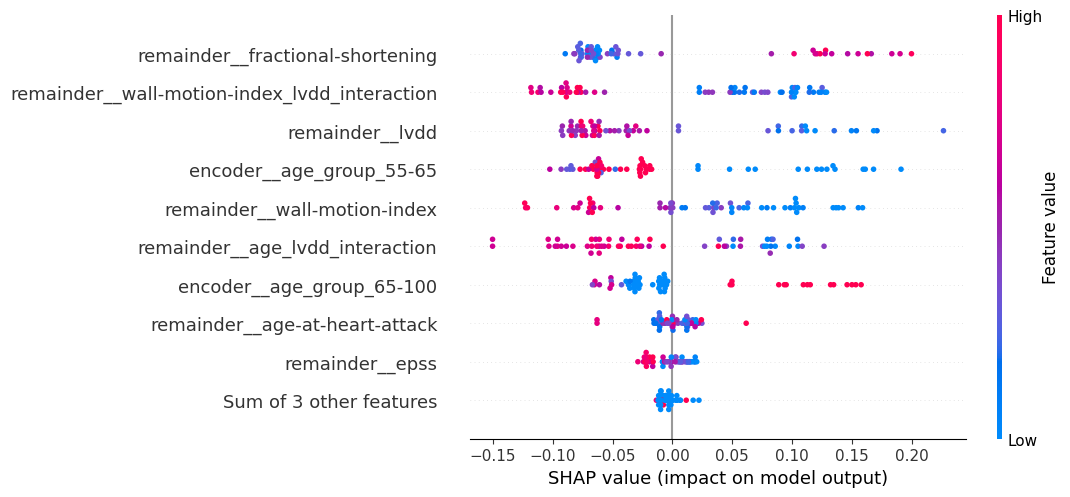

In [63]:
# Random Forest SHAP values
explainer = shap.TreeExplainer(rf_best_estimator)
shap_values = explainer(X_test, y_test)
shap.plots.beeswarm(shap_values[..., 0])

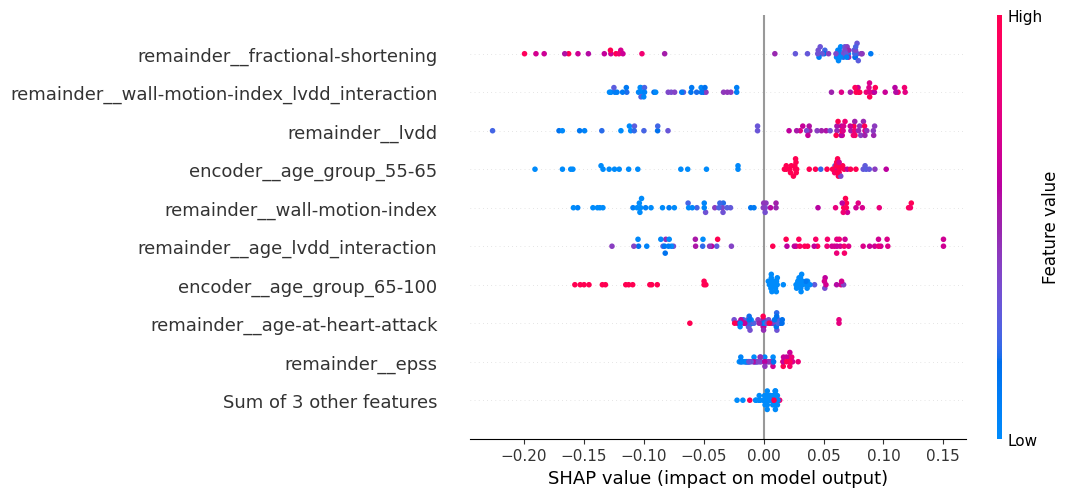

In [64]:
# Random Forest SHAP values
explainer = shap.TreeExplainer(rf_best_estimator)
shap_values = explainer(X_test, y_test)
shap.plots.beeswarm(shap_values[..., 1])

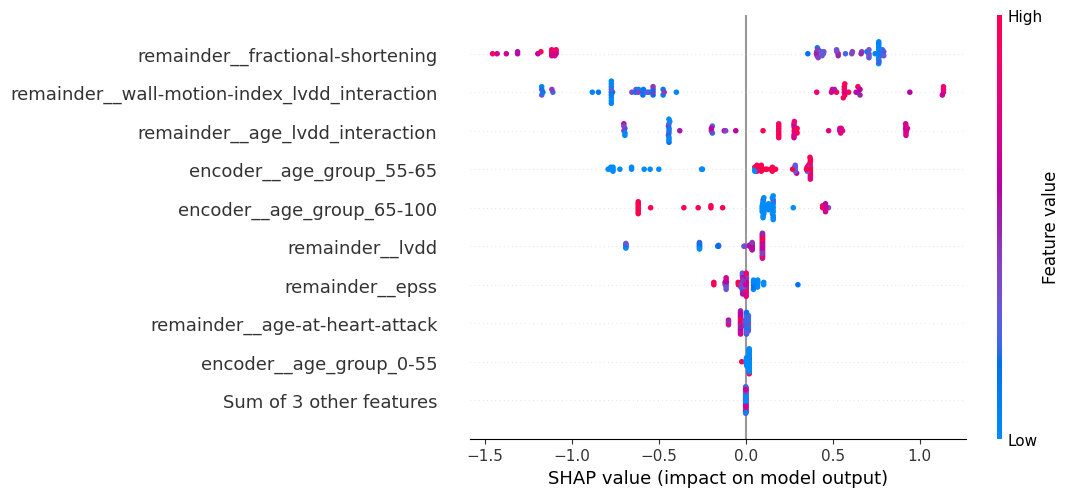

In [65]:
# XGBoost SHAP values
explainer = shap.TreeExplainer(xgboost_best_estimator)
shap_values = explainer(X_test, y_test)
shap.plots.beeswarm(shap_values)

# Bonus: Model Stacking

##### Let's check if we can build a better predictor by combining the powers of Random Forest and XGBoost using Stacking Classifier

In [66]:
def stack_model1(X_train, y_train, X_test, y_test):

    estimators = [
        ('rf', rf_best_estimator),
        ('xgboost', xgboost_best_estimator)]

    clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())

    clf.fit(X_train, y_train)

    # Predict the target variable for the test data
    y_pred = clf.predict(X_test)

    # # Probability of positive class
    y_pred_proba = clf.predict_proba(X_test)[:, 1]

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred) # accuracy
    roc_auc = roc_auc_score(y_test, y_pred_proba) # Compute ROC AUC
    f1_macro = f1_score(y_test, y_pred, average='macro') # f1 macro score
    conf_matrix = confusion_matrix(y_test, y_pred)
    clf_report = classification_report(y_test, y_pred)

    print("Accuracy: {:.2f} %".format(accuracy*100))
    print("ROC AUC: {:.2f} %".format(roc_auc*100))
    print("f1 macro score: {:.2f} %".format(f1_macro*100))

    # Confusion Matrix
    print("Confusion Matrix:\n", conf_matrix)

    # Classification Report
    print("Classification Report:\n", clf_report)

In [67]:
# Stack Model1 Evaluation
stack_model1(X_train, y_train, X_test, y_test)

Accuracy: 98.28 %
ROC AUC: 100.00 %
f1 macro score: 98.27 %
Confusion Matrix:
 [[30  1]
 [ 0 27]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.98        31
           1       0.96      1.00      0.98        27

    accuracy                           0.98        58
   macro avg       0.98      0.98      0.98        58
weighted avg       0.98      0.98      0.98        58



##### Let's check if we can build a better predictor by combining the powers of Random Forest and XGBoost using a Voting Classifier

In [68]:
def stack_model2(X_train, y_train, X_test, y_test):

    estimators = [
        ('rf', rf_best_estimator),
        ('xgboost', xgboost_best_estimator)]

    clf = VotingClassifier(estimators=estimators, voting='soft')

    clf.fit(X_train, y_train)

    # Predict the target variable for the test data
    y_pred = clf.predict(X_test)

    # # Probability of positive class
    y_pred_proba = clf.predict_proba(X_test)[:, 1]

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred) # accuracy
    roc_auc = roc_auc_score(y_test, y_pred_proba) # Compute ROC AUC
    f1_macro = f1_score(y_test, y_pred, average='macro') # f1 macro score
    conf_matrix = confusion_matrix(y_test, y_pred)
    clf_report = classification_report(y_test, y_pred)

    print("Accuracy: {:.2f} %".format(accuracy*100))
    print("ROC AUC: {:.2f} %".format(roc_auc*100))
    print("f1 macro score: {:.2f} %".format(f1_macro*100))

    # Confusion Matrix
    print("Confusion Matrix:\n", conf_matrix)

    # Classification Report
    print("Classification Report:\n", clf_report)

In [69]:
# Stack Model2 Evaluation
stack_model2(X_train, y_train, X_test, y_test)

Accuracy: 98.28 %
ROC AUC: 100.00 %
f1 macro score: 98.27 %
Confusion Matrix:
 [[30  1]
 [ 0 27]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.98        31
           1       0.96      1.00      0.98        27

    accuracy                           0.98        58
   macro avg       0.98      0.98      0.98        58
weighted avg       0.98      0.98      0.98        58



# Saving Models

In [70]:
import joblib

# Saving Standard Scaler
#scaler_filename = "model/standard_scaler.gz"
#joblib.dump(sc, scaler_filename)

In [71]:
import pickle

# save the Random Forest model to disk
#filename = 'model/RandomForest.sav'
#pickle.dump(rf_best_estimator, open(filename, 'wb'))

# save the XGBoost Classifier model to disk
#filename = 'model/XGBoost.sav'
#pickle.dump(xgboost_best_estimator, open(filename, 'wb'))

# Confusion Matrix Plot

In [72]:
# Random Forest
y_pred = rf_best_estimator.predict(X_test) # Predict the target variable for the test data 
plotly_fig = cm_plot(rf_best_estimator, y_test, y_pred, classes=["Not Survived", "Survived"], save_fig_path="model/RandomForest_CM.html")
plotly_fig

In [73]:
# XGBoost
y_pred = xgboost_best_estimator.predict(X_test) # Predict the target variable for the test data 
plotly_fig = cm_plot(xgboost_best_estimator, y_test, y_pred, classes=["Not Survived", "Survived"], save_fig_path="model/XGBoost_CM.html")
plotly_fig

# Read the Plotly Figure from a StandAlone HTML file

In [74]:
import plotly
def read_from_json(json_file):
    return plotly.io.read_json(json_file)

In [75]:
read_from_json("model/RandomForest_CM.json")

In [76]:
# Save important numpy arrays
np.save('model/x_train.npy', X_train)
np.save('model/x_test.npy', X_test)
np.save('model/y_train.npy', y_train)
np.save('model/y_test.npy', y_test)

# Discriminant Threshold

In [118]:
# For some reason I have to encrypt the contents of the discrimination threshold (285 lines) and confusion_matrix_plot (141 lines) functions. 
# You can contact me if you want to decrypt discrimination_threshold_plot.py.enc and confusion_matrix.py.enc files

# Random Forest Model
plotly_fig, fig, ax, disc_threshold = plot_threshold(rf_best_estimator, X_test, y_test, argmax='f1',
                                title='Metrics vs Discriminant Threshold',
                                fig_size=(8, 6), dpi=100,
                                save_fig_path="model/rf_disc_threshold.html")

plotly_fig

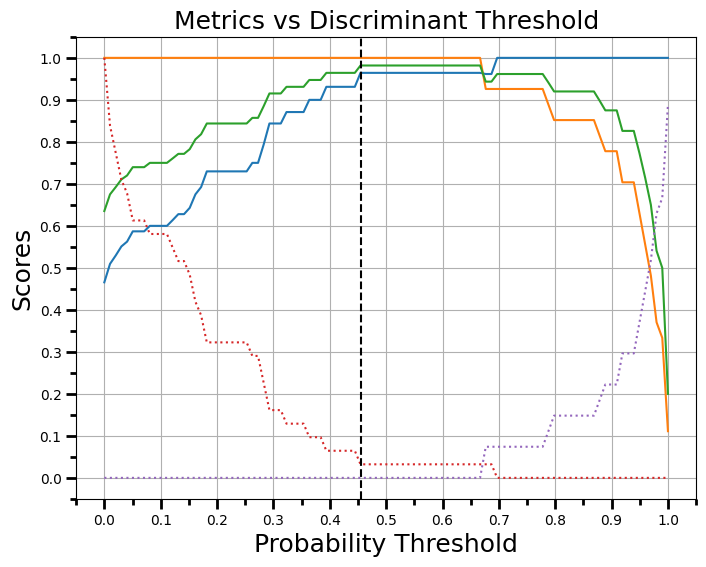

In [119]:
fig

In [120]:
# XGBoost Forest Model
plotly_fig, fig, ax, disc_threshold = plot_threshold(xgboost_best_estimator, X_test, y_test, argmax='f1',
                                title='Metrics vs Discriminant Threshold',
                                fig_size=(8, 6), dpi=100,
                                save_fig_path="model/xgboost_disc_threshold.html")

plotly_fig

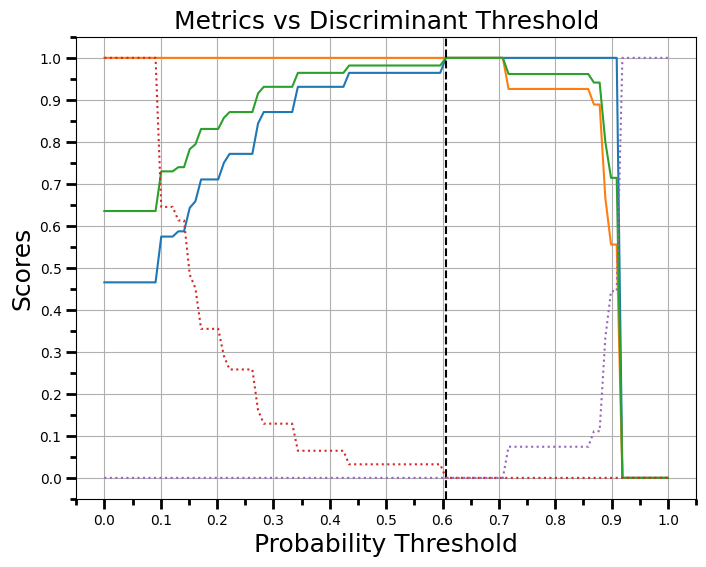

In [121]:
fig